## Ансамблевый классификатор (логистическая регрессия, дерево решений и k ближайших соседей)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

В качестве набора данных используем датасет цветков ириса и выберем два признака - ширину чашелистика и длину лепестка.
Классификацию проведем для образцов из двух классов - Iгis veгsicolor и Iгis viгginica (отберем данные с 50-й строки).

In [2]:
ds_iris = load_iris()
X = ds_iris.data[50:,[1,2]]
y = ds_iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y) # кодируем метки класса
y, y.shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), (100,))

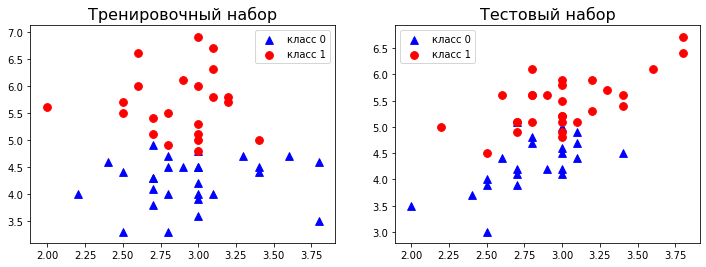

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].scatter(X_test[y_train==0,0], X_train[y_train==0,1], 
              c='b', marker='^', s=60, label='класс 0')
ax[0].scatter(X_test[y_train==1,0], X_train[y_train==1,1], 
              c='r', marker='o', s=60, label='класс 1')
ax[0].set_title('Тренировочный набор', fontsize=16)
ax[0].legend()
ax[1].scatter(X_test[y_test==0,0], X_test[y_test==0,1], 
              c='b', marker='^', s=60, label='класс 0')
ax[1].scatter(X_test[y_test==1,0], X_test[y_test==1,1], 
              c='r', marker='o', s=60, label='класс 1')
ax[1].set_title('Тестовый набор', fontsize=16)
ax[1].legend()

Сравним площади под RОС-кривой (ROC AUC) для каждой индивидуальной модели и ансамблевой модели с применением 10-блочной перекрестной проверки на тренировочном наборе данных.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline


clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# для алгоритмов логистической регрессии и kNN требуется шкалирование данных
# проведем стандартизацию в соответствующих конвейерах и далее работаем с ними
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

# наш ансамблевый классификатор
clf4 = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

clf_labels = ['Logistic Regression', 'Decision Tree', 'kNN', 'Voting']
print('\n10-блочная перекрестная проверка: \n')
for clf, label in zip([pipe1, clf2, pipe3, clf4], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train ,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) <%s> " 
          % (scores.mean(), scores.std(), label))


10-блочная перекрестная проверка: 

ROC AUC: 0.97 (+/- 0.10) <Logistic Regression> 
ROC AUC: 0.93 (+/- 0.11) <Decision Tree> 
ROC AUC: 0.93 (+/- 0.15) <kNN> 
ROC AUC: 0.98 (+/- 0.05) <Voting> 


Оценим эти модели на тестовом наборе данных с построением ROC-кривых.

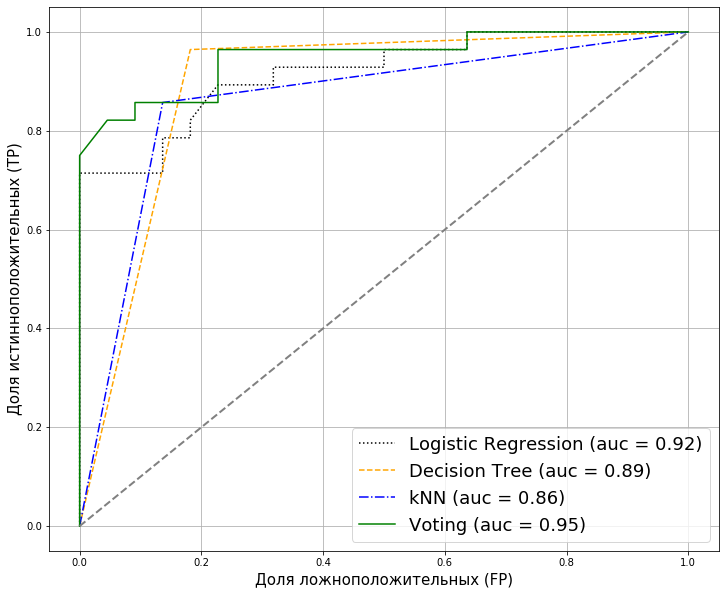

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
plt.figure(figsize=(12,10))
for clf, label, clr, ls in zip(
    [pipe1, clf2, pipe3, clf4], clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right', prop={'size': 18})
plt.plot([0,1], [0,1], 
         linestyle='--', 
         color='gray',
         linewidth=2)
#plt.xlim([-0.1, 1.1])
#plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Дoля ложноположительных (FP)', fontsize=15)
plt.ylabel('Дoля истинноположительных (TP)', fontsize=15)
plt.show()

In [6]:
##################

In [7]:
ds_wine = load_wine()
df = pd.DataFrame(ds_wine.data, columns = ds_wine.feature_names)
df['class_label'] = ds_wine.target
df.head()
df_wine = df[df['class_label'] != 1]
#print(ds_wine.DESCR)
df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class_label
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,13.479626,2.604206,2.447290,19.001869,103.186916,2.319159,1.995047,0.360654,1.564766,6.366262,0.891869,2.496449,897.775701,0.897196
std,0.573348,1.105115,0.208438,3.255387,11.190571,0.675408,1.155059,0.125347,0.553097,2.019544,0.221718,0.803295,302.746931,0.999383
min,12.200000,1.240000,2.040000,11.200000,80.000000,0.980000,0.340000,0.170000,0.550000,3.520000,0.480000,1.270000,415.000000,0.000000
25%,13.060000,1.725000,2.300000,16.750000,95.000000,1.680000,0.725000,0.265000,1.140000,4.960000,0.690000,1.700000,645.000000,0.000000
50%,13.500000,2.050000,2.410000,19.000000,102.000000,2.450000,2.430000,0.320000,1.540000,5.700000,0.910000,2.730000,845.000000,0.000000
75%,13.865000,3.410000,2.610000,21.000000,111.500000,2.850000,2.995000,0.460000,1.970000,7.550000,1.075000,3.200000,1112.500000,2.000000
max,14.830000,5.650000,3.220000,27.000000,132.000000,3.880000,3.930000,0.630000,2.960000,13.000000,1.280000,4.000000,1680.000000,2.000000


In [8]:
y = df_wine['class_label'].values
X = df_wine[['alcohol', 'total_phenols']].values

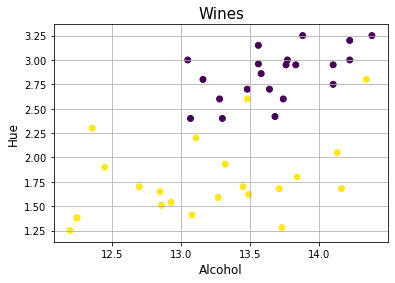

In [9]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40, random_state=1)
plt.title('Wines', fontdict={'fontsize': 15})
plt.xlabel('Alcohol', fontdict={'fontsize': 12})
plt.ylabel('Hue', fontdict={'fontsize': 12})
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)

## Bagging

Accuracy tree model train/test data: 1.000/0.907


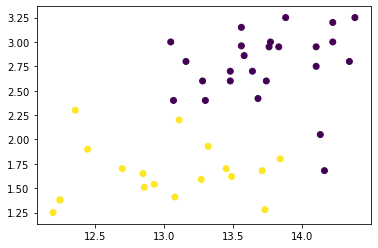

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Accuracy tree model train/test data: %.3f/%.3f' %(tree_train, tree_test))
plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred)

Accuracy Bagging train/test data: 1.000/0.953


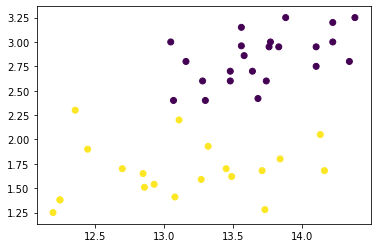

In [11]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Accuracy Bagging train/test data: %.3f/%.3f' %(bag_train, bag_test))
plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred)

## Адаптивный бустинг (AdaBoost)

Accuracy tree model train/test data: 0.984/0.953


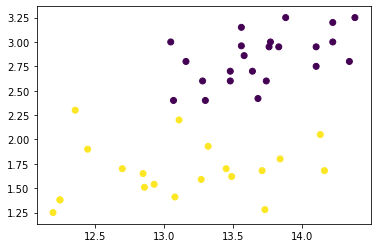

In [12]:
from sklearn.ensemble import AdaBoostClassifier


tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=0)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=0)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Accuracy tree model train/test data: %.3f/%.3f' %(tree_train, tree_test))
plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred)

Accuracy Adaboost model train/test data: 1.000/0.907


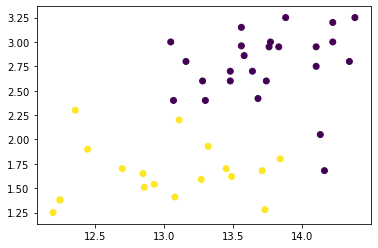

In [13]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('Accuracy Adaboost model train/test data: %.3f/%.3f' %(ada_train, ada_test))
plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred)